In [15]:
import os, sys
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
sys.path.append('..')
from tqdm import tqdm
import argparse
from omegaconf import OmegaConf
from types import MethodType

import torch
import lightning as L
from src.pal_rm_b.lightningmodule import LearnerWrapLightning

In [16]:
checkpoint = torch.load('/home/daiwei/projects/pal/refactored-diverse-alignment/ckpts/summary-b-seen-epoch=00-f7f8.ckpt')
prefLearner_config = OmegaConf.load('../config/prefLearner_config/b-dim512-k2-opt350m-mlp2.yaml')
optim_config = OmegaConf.load('../config/optim_config/vanilla-e1.yaml')
loss_config = OmegaConf.load('../config/loss_config/b-cumulative.yaml')
ds_config = OmegaConf.load('../config/ds_config/summary.yaml')
uids = torch.load(ds_config.user_ids_path)
state_dict = checkpoint['state_dict']

pal = LearnerWrapLightning(prefLearner_config, optim_config, loss_config)
pal.prefLearner.user_learner.init_weight(uids)

2024-09-13 17:22:22,062 - src.pal_rm_b.learner - CRITICAL - 🛑 Remember to call update_trainable_params() after the model is initialized.


the upper bound is 4.0


In [17]:
def load_ckpt_learner(learner, ckpt_path):
    state_dict = torch.load(ckpt_path,map_location='cpu')['state_dict']
    learner.load_state_dict(state_dict)
    return learner

pal = load_ckpt_learner(pal, '/home/daiwei/projects/pal/refactored-diverse-alignment/ckpts/summary-b-seen-epoch=00-f7f8.ckpt')

In [18]:
def wrap_mix_forward_b(pal: torch.nn.Module, mix_weight: torch.tensor):
    # override the forward function of the pal to be a standard reward model
    # after the modification, the pal will be able to output:
    # model a: the reward diff given a prompt
    # model b: the reward logits given a prompt
    def mix_forward_userlearner(self, prompt_tokens):
        prompt_logits = self.infer_gk(prompt_tokens)
        bs = prompt_tokens['input_ids'].size(0)
        w = self.softmax(mix_weight.repeat(bs, 1))
        w = w.unsqueeze(-1).unsqueeze(-1)
        y_hat = (w * prompt_logits).sum(dim=1)
        self.tmp_store_user_ideal_points = y_hat
        return y_hat
    def mix_forward_itemlearner(self, items):
        embeds = self.llm(input_ids=items['input_ids'], attention_mask=items['attention_mask']).last_hidden_state
        # embeds shape: (bs, seq_len, hidden_size)
        shape = embeds.shape
        embeds = embeds.view(-1, shape[-1]) # (bs*seq_len, hidden_size)
        projected_embeds = self.projector(embeds)
        return projected_embeds.view(shape[0], shape[1], -1)
    def mix_map_preflearner(self, x):
        # ({
        # 'input_ids': prompt_input_ids,\
        # 'attention_mask': prompt_attention_mask,
        # },\
        # {
        # 'input_ids': eval_input_ids,\
        # 'attention_mask': eval_attention_mask,\
        # })
        prompt, items = x
        items_prime = self.item_learner(items)
        prompt_prime = self.user_learner(prompt)
        return items_prime, prompt_prime
    def mix_forward_preflearner(self, x):
        items, prompt = x
        items_prime, prompt_prime = self.map_to_pref_embedding_space((prompt, items))
        print(f"{items_prime[0]=}")
        print(f"{prompt_prime[0]=}")
        print(f"{items_prime.shape=}")
        print(f"{prompt_prime.shape=}")
        if self.pref_learner_type == 'angle':
            items_prime = items_prime / torch.norm(items_prime, dim=-1, keepdim=True)
            prompt_prime = prompt_prime / torch.norm(prompt_prime, dim=-1, keepdim=True)
            prompt_prime = prompt_prime.unsqueeze(1)
            logit_scale = self.logit_scale.exp()
            clamped_logit_scale = torch.clamp(logit_scale, max=100)
            print(clamped_logit_scale)
            print((prompt_prime * items_prime).sum(dim=-1))
            sim_score = (prompt_prime * items_prime).sum(dim=-1) * clamped_logit_scale   # (bs, max_token_length)
            return sim_score
        else:
            raise NotImplementedError
    def forwad(self, batch):
        y_hat = self.prefLearner(batch)
        return y_hat
    pal.prefLearner.user_learner.forward = MethodType(mix_forward_userlearner, pal.prefLearner.user_learner)
    pal.prefLearner.item_learner.forward = MethodType(mix_forward_itemlearner, pal.prefLearner.item_learner)
    pal.prefLearner.map_to_pref_embedding_space = MethodType(mix_map_preflearner, pal.prefLearner)
    pal.prefLearner.forward = MethodType(mix_forward_preflearner, pal.prefLearner)
    pal.forward = MethodType(forwad, pal)
    return pal

def wrap_mix_forward_a(pal: torch.nn.Module, mix_weight: torch.tensor):
    # override the forward function of the pal to be a standard reward model
    # after the modification, the pal will be able to output:
    # model a: the reward diff given a prompt
    # model b: the reward logits given a prompt
    def mix_forward_userlearner(self):
        w = self.softmax(mix_weight.unsqueeze(0))
        if self.learner_type == 'f(Pw)':
            res = self.projector(w @ self.P)
            return res
        elif self.learner_type == 'f(P)w':
            res = w @ self.projector(self.P)
            return res
        elif self.learner_type == 'Pw':
            res = w @ self.P
            return res
        else:
            raise NotImplementedError
    def mix_forward_itemlearner(self, items):
        
        ...
    def mix_map_preflearner(self, x):
        # {
        # 'input_ids': input_ids,\
        # 'attention_mask': attention_mask,\
        # }
        items = x
        x_left_prime, x_right_prime = self.item_learner(items)
        u_prime = self.user_learner()
        bs = items['left_input_ids'].size(0)
        u_prime = u_prime.repeat(bs, 1)
        return x_left_prime, x_right_prime, u_prime
    
    def forwad(self, batch):
        y_hat = self.prefLearner(batch)
        return y_hat
    pal.prefLearner.user_learner.forward = MethodType(mix_forward_userlearner, pal.prefLearner.user_learner)
    pal.prefLearner.map_to_pref_embedding_space = MethodType(mix_map_preflearner, pal.prefLearner)
    pal.forward = MethodType(forwad, pal)
    return pal

In [19]:
pal = wrap_mix_forward_b(pal, torch.tensor([0.5]))

In [20]:
prompt_input_ids = torch.tensor([[101, 1045, 2515, 1037, 2515, 1012, 102]])
prompt_attention_mask = torch.ones_like(prompt_input_ids)
chosen_input_ids = torch.tensor([[101, 1045, 2515, 1037, 2515, 1012, 102]])
chosen_attention_mask = torch.ones_like(chosen_input_ids)
rejected_input_ids = torch.tensor([[101, 1045, 2515, 1037, 2515, 1012, 102]])
rejected_attention_mask = torch.ones_like(rejected_input_ids)

tmp = (
    {
    'input_ids': prompt_input_ids,
    'attention_mask': prompt_attention_mask,
    },
    {
    'input_ids': chosen_input_ids,
    'attention_mask': chosen_attention_mask,
    }
)

In [21]:
pal(tmp)

items_prime[0]=tensor([[ 0.1154, -0.2059, -0.0034,  ..., -1.0721,  0.2010,  0.1516],
        [ 0.1147, -0.2062, -0.0038,  ..., -1.0724,  0.2012,  0.1545],
        [ 0.1114, -0.2021, -0.0040,  ..., -1.0498,  0.1971,  0.1544],
        ...,
        [ 0.1092, -0.2000, -0.0043,  ..., -1.0371,  0.1949,  0.1557],
        [ 0.1089, -0.1996, -0.0044,  ..., -1.0351,  0.1945,  0.1558],
        [ 0.1078, -0.1984, -0.0045,  ..., -1.0283,  0.1933,  0.1561]],
       grad_fn=<SelectBackward0>)
prompt_prime[0]=tensor([[-0.0154, -0.0049, -0.0240,  ...,  0.0105,  0.0029,  0.1155],
        [-0.0154, -0.0053, -0.0248,  ...,  0.0097,  0.0032,  0.1182],
        [-0.0151, -0.0058, -0.0249,  ...,  0.0100,  0.0037,  0.1185],
        ...,
        [-0.0150, -0.0062, -0.0252,  ...,  0.0102,  0.0041,  0.1201],
        [-0.0150, -0.0064, -0.0254,  ...,  0.0101,  0.0043,  0.1206],
        [-0.0149, -0.0066, -0.0255,  ...,  0.0103,  0.0045,  0.1210]],
       grad_fn=<SelectBackward0>)
items_prime.shape=torch.Size([1, 

tensor([[[-1.0261, -0.6946, -0.2817, -0.2098,  0.1325,  0.1900,  0.3622]]],
       grad_fn=<MulBackward0>)

In [35]:
torch.save(pal, 'tmp_model.pth')

In [36]:
torch.save(pal.state_dict(), 'tmp.pth')

In [37]:
pal_a = LearnerWrapLightning(prefLearner_config, optim_config, loss_config)
pal_a.prefLearner.user_learner.init_weight(uids)
pal_a = wrap_mix_forward_b(pal_a, torch.tensor([0.5]))

2024-09-13 11:41:05,551 - src.pal_rm_b.learner - CRITICAL - 🛑 Remember to call update_trainable_params() after the model is initialized.


the upper bound is 4.0


In [38]:
pal_a.load_state_dict(torch.load('tmp.pth'))

<All keys matched successfully>

In [39]:
pal_a(tmp)

items_prime[0]=tensor([[-0.4623, -3.6934,  1.5608,  ..., -1.7927,  3.0306, -1.9023],
        [-0.0801, -3.2334,  4.6325,  ...,  0.1047,  2.6710, -2.0856],
        [-0.2887, -3.6674,  3.5159,  ..., -1.6389,  2.6698, -3.2263],
        ...,
        [ 0.1620,  1.5926,  1.5016,  ..., -1.9584,  2.0274, -2.0478],
        [-0.1873,  4.0954,  1.5305,  ..., -1.8824,  1.8769, -0.5328],
        [-0.3072,  2.4888,  2.3021,  ..., -0.5701,  1.8019, -1.1066]],
       grad_fn=<SelectBackward0>)
prompt_prime[0]=tensor([[-0.4616, -3.6943,  1.5638,  ..., -1.7951,  3.0320, -1.9020],
        [-0.0793, -3.2343,  4.6356,  ...,  0.1023,  2.6724, -2.0853],
        [-0.2879, -3.6683,  3.5189,  ..., -1.6413,  2.6711, -3.2259],
        ...,
        [ 0.1628,  1.5917,  1.5047,  ..., -1.9608,  2.0287, -2.0475],
        [-0.1866,  4.0945,  1.5336,  ..., -1.8848,  1.8782, -0.5324],
        [-0.3065,  2.4878,  2.3051,  ..., -0.5725,  1.8032, -1.1062]],
       grad_fn=<SelectBackward0>)
items_prime.shape=torch.Size([1, 

tensor([[[3.2628, 3.2628, 3.2628, 3.2628, 3.2628, 3.2628, 3.2628]]],
       grad_fn=<MulBackward0>)

In [40]:
pal_b = LearnerWrapLightning(prefLearner_config, optim_config, loss_config)
pal_b.prefLearner.user_learner.init_weight(uids)
pal_b = wrap_mix_forward_b(pal_b, torch.tensor([0.5]))

2024-09-13 11:41:06,979 - src.pal_rm_b.learner - CRITICAL - 🛑 Remember to call update_trainable_params() after the model is initialized.


the upper bound is 4.0


In [41]:
def load_ckpt_learner(learner, ckpt_path):
    state_dict = torch.load(ckpt_path,map_location='cpu')['state_dict']
    learner.load_state_dict(state_dict)
    return learner

In [42]:
load_ckpt_learner(pal_b, '../ckpts/summary-b-seen-epoch=02-bc92.ckpt')

LearnerWrapLightning(
  (prefLearner): PrefLearner_angle(
    (llm): OPTModel(
      (decoder): OPTDecoder(
        (embed_tokens): Embedding(50272, 512, padding_idx=1)
        (embed_positions): OPTLearnedPositionalEmbedding(2050, 1024)
        (project_out): Linear(in_features=1024, out_features=512, bias=False)
        (project_in): Linear(in_features=512, out_features=1024, bias=False)
        (layers): ModuleList(
          (0-23): 24 x OPTDecoderLayer(
            (self_attn): OPTAttention(
              (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (activation_fn): ReLU()
            (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (fc1): Linear(in_features=1

In [43]:
pal_b(tmp)

items_prime[0]=tensor([[-0.4623, -3.6934,  1.5608,  ..., -1.7927,  3.0306, -1.9023],
        [-0.0801, -3.2334,  4.6325,  ...,  0.1047,  2.6710, -2.0856],
        [-0.2887, -3.6674,  3.5159,  ..., -1.6389,  2.6698, -3.2263],
        ...,
        [ 0.1620,  1.5926,  1.5016,  ..., -1.9584,  2.0274, -2.0478],
        [-0.1873,  4.0954,  1.5305,  ..., -1.8824,  1.8769, -0.5328],
        [-0.3072,  2.4888,  2.3021,  ..., -0.5701,  1.8019, -1.1066]],
       grad_fn=<SelectBackward0>)
prompt_prime[0]=tensor([[-0.4616, -3.6943,  1.5638,  ..., -1.7951,  3.0320, -1.9020],
        [-0.0793, -3.2343,  4.6356,  ...,  0.1023,  2.6724, -2.0853],
        [-0.2879, -3.6683,  3.5189,  ..., -1.6413,  2.6711, -3.2259],
        ...,
        [ 0.1628,  1.5917,  1.5047,  ..., -1.9608,  2.0287, -2.0475],
        [-0.1866,  4.0945,  1.5336,  ..., -1.8848,  1.8782, -0.5324],
        [-0.3065,  2.4878,  2.3051,  ..., -0.5725,  1.8032, -1.1062]],
       grad_fn=<SelectBackward0>)
items_prime.shape=torch.Size([1, 

tensor([[[3.2628, 3.2628, 3.2628, 3.2628, 3.2628, 3.2628, 3.2628]]],
       grad_fn=<MulBackward0>)

In [44]:
import logging
logging.basicConfig(level=logging.WARNING, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def load_pal_rm_b(
    mix_weight: torch.tensor,
    pref_Learner_config_path: str,
    optim_config_path: str,
    loss_config_path: str,
    ds_config_path: str,
    state_dict_path: str,
    **kwargs,
):
    logger.critical(' 💠 load configurations...')
    prefLearner_config = OmegaConf.load(pref_Learner_config_path)
    optim_config = OmegaConf.load(optim_config_path)
    loss_config = OmegaConf.load(loss_config_path)
    ds_config = OmegaConf.load(ds_config_path)
    uids = torch.load(ds_config.user_ids_path)
    logger.critical(' 💠 initiaize pal_rm model...')
    pal = LearnerWrapLightning(prefLearner_config, optim_config, loss_config)
    pal.prefLearner.user_learner.init_weight(uids)
    pal_rm = wrap_mix_forward_b(pal, mix_weight)
    load_ckpt_learner(pal_rm, state_dict_path)
    logger.critical(' 💠 complete reformat: pal -> pal_rm!')
    return pal_rm

In [45]:
pal_c = load_pal_rm_b(
    mix_weight=torch.tensor([0.5]),
    pref_Learner_config_path='../config/prefLearner_config/b-dim512-k1-opt350m-mlp2.yaml',
    optim_config_path='../config/optim_config/vanilla-e1.yaml',
    loss_config_path='../config/loss_config/b-cumulative.yaml',
    ds_config_path='../config/ds_config/summary.yaml',
    state_dict_path='../ckpts/summary-b-seen-epoch=02-bc92.ckpt',
)

2024-09-13 11:41:16,884 - __main__ - CRITICAL -  💠 load configurations...
2024-09-13 11:41:16,895 - __main__ - CRITICAL -  💠 initiaize pal_rm model...
2024-09-13 11:41:17,198 - src.pal_rm_b.learner - CRITICAL - 🛑 Remember to call update_trainable_params() after the model is initialized.


the upper bound is 4.0


2024-09-13 11:41:19,599 - __main__ - CRITICAL -  💠 complete reformat: pal -> pal_rm!


In [46]:
pal_c(tmp)

items_prime[0]=tensor([[-0.4623, -3.6934,  1.5608,  ..., -1.7927,  3.0306, -1.9023],
        [-0.0801, -3.2334,  4.6325,  ...,  0.1047,  2.6710, -2.0856],
        [-0.2887, -3.6674,  3.5159,  ..., -1.6389,  2.6698, -3.2263],
        ...,
        [ 0.1620,  1.5926,  1.5016,  ..., -1.9584,  2.0274, -2.0478],
        [-0.1873,  4.0954,  1.5305,  ..., -1.8824,  1.8769, -0.5328],
        [-0.3072,  2.4888,  2.3021,  ..., -0.5701,  1.8019, -1.1066]],
       grad_fn=<SelectBackward0>)
prompt_prime[0]=tensor([[-0.4616, -3.6943,  1.5638,  ..., -1.7951,  3.0320, -1.9020],
        [-0.0793, -3.2343,  4.6356,  ...,  0.1023,  2.6724, -2.0853],
        [-0.2879, -3.6683,  3.5189,  ..., -1.6413,  2.6711, -3.2259],
        ...,
        [ 0.1628,  1.5917,  1.5047,  ..., -1.9608,  2.0287, -2.0475],
        [-0.1866,  4.0945,  1.5336,  ..., -1.8848,  1.8782, -0.5324],
        [-0.3065,  2.4878,  2.3051,  ..., -0.5725,  1.8032, -1.1062]],
       grad_fn=<SelectBackward0>)
items_prime.shape=torch.Size([1, 

tensor([[[3.2628, 3.2628, 3.2628, 3.2628, 3.2628, 3.2628, 3.2628]]],
       grad_fn=<MulBackward0>)

In [74]:
a = torch.randn(1, 512)
b = torch.randn(1, 512)

In [75]:
a = a / torch.norm(a, dim=-1, keepdim=True)
b = b / torch.norm(b, dim=-1, keepdim=True)

In [76]:
(a * b).sum(dim=-1)

tensor([0.0603])

# check the group structure

In [44]:
W = pal.prefLearner.user_learner.W

In [45]:
W_extract = [W[i].detach().numpy() for i in W.keys()]

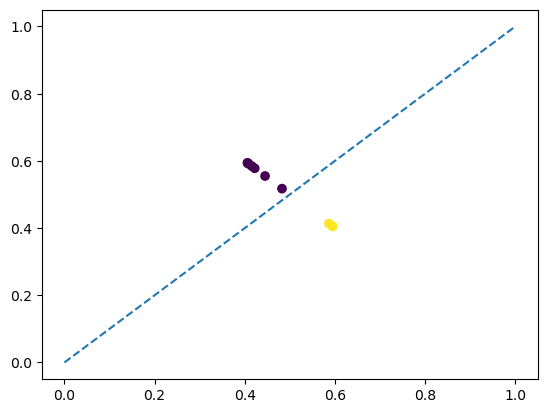

: 

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

W_extract = np.stack(W_extract)
W_extract = F.softmax(torch.tensor(W_extract), dim=1).numpy()

minority = [3, 4, 5]
majority = [0, 1, 2, 6, 7, 8, 9]

# create color index, different for minority and majority
color_idx = np.zeros(10)
color_idx[minority] = 1
color_idx[majority] = 0

plt.scatter(W_extract[:, 0], W_extract[:, 1], c=color_idx)
plt.plot([0, 1], [0, 1], '--')